In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

pd.set_option('display.max_columns', None)

In [2]:
df_kobe = pd.read_csv('Kobe.csv')

# Для удобства категориальные переменные переведем в тип category

df_kobe.set_index('shot_id', inplace=True)
df_kobe["action_type"] = df_kobe["action_type"].astype('object')
df_kobe["combined_shot_type"] = df_kobe["combined_shot_type"].astype('category')
df_kobe["game_event_id"] = df_kobe["game_event_id"].astype('category')
df_kobe["game_id"] = df_kobe["game_id"].astype('category')
df_kobe["period"] = df_kobe["period"].astype('object')
df_kobe["playoffs"] = df_kobe["playoffs"].astype('category')
df_kobe["season"] = df_kobe["season"].astype('category')
df_kobe["shot_made_flag"] = df_kobe["shot_made_flag"].astype('category')
df_kobe["shot_type"] = df_kobe["shot_type"].astype('category')
df_kobe["team_id"] = df_kobe["team_id"].astype('category')

# Удаляем ненужные признаки
df_kobe.drop('team_id', axis=1, inplace=True) # Всегда один и тот же номер
df_kobe.drop('game_id', axis=1, inplace=True) # Независимый признак
df_kobe.drop('game_event_id', axis=1, inplace=True) # Независимый признак
df_kobe.drop('team_name', axis=1, inplace=True) # Везде одна и та же команда

df_kobe[:5]

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR


## Визуализация данных

Проверим наличие пропущенных значений в признаках

In [3]:
print('Статистика пропущенных значений:\n')
for colname in df_kobe.columns:
    stat = df_kobe[colname].isna().mean() * 100
    print(f'{colname}: {round(stat, 2)}%')

Статистика пропущенных значений:

action_type: 0.0%
combined_shot_type: 0.0%
lat: 0.0%
loc_x: 0.0%
loc_y: 0.0%
lon: 0.0%
minutes_remaining: 0.0%
period: 0.0%
playoffs: 0.0%
season: 0.0%
seconds_remaining: 0.0%
shot_distance: 0.0%
shot_made_flag: 16.29%
shot_type: 0.0%
shot_zone_area: 0.0%
shot_zone_basic: 0.0%
shot_zone_range: 0.0%
game_date: 0.0%
matchup: 0.0%
opponent: 0.0%


In [4]:
print(f'Типы данных в признаках датасета:\n\n{df_kobe.dtypes}')

Типы данных в признаках датасета:

action_type             object
combined_shot_type    category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
game_date               object
matchup                 object
opponent                object
dtype: object


Проверим корреляцию между признаками

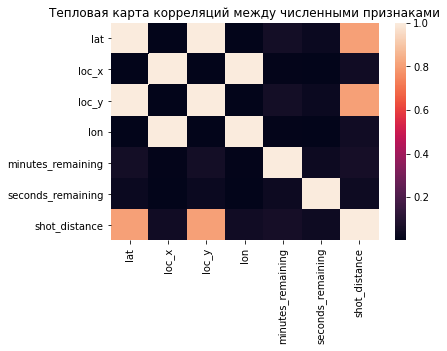

In [5]:
sns.heatmap(df_kobe.corr(method='spearman').apply(np.abs))
plt.title("Тепловая карта корреляций между численными признаками")
plt.show()

Как видно из тепловой карты у нас сильно крррелируют между собой lat и loc_y, lon и loc_x.

Посмотрим на стандартные статистчиеские метрики (медиана, СКО и др.)

In [6]:
df_kobe.describe(include=['float64', 'int64'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [7]:
df_kobe.describe(include=['object', 'category'])

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697
unique,57,6,7,2,20,2.0,2,6,7,5,1559,74,33
top,Jump Shot,Jump Shot,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,8296,26198,2318,14232.0,24271,13455,12625,9398,50,1020,1978


Сильных выбросов в данных не наблюдается. loc_x и loc_y имеют большое СКО, эти признаки преобразуем в категориальные с помощью бинов.

Проверим распределение по целевой переменной.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


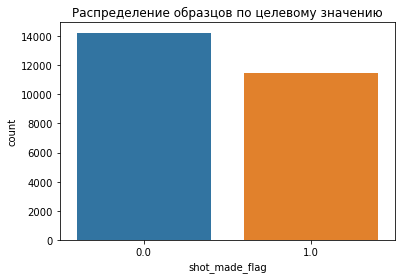

In [8]:
sns.countplot(x='shot_made_flag', data=df_kobe)
plt.title('Распределение образцов по целевому значению')
plt.show()

Явного дисбаланса не наблюдается, поэтому оставим данные как есть.

## Подготовка данных и создание признаков

In [9]:
df_kobe.drop('lat', axis=1, inplace=True) # Сильно коорелирует с loc_x
df_kobe.drop('lon', axis=1, inplace=True) # Сильно коррелирует с loc_y

# Могут иметь значения последние 5 секунд до окончания игры, так как человек может играть более активно и идти на риски.
# Нам важно узнать было попадание или промах почти в конце раунда или нет
df_kobe['seconds_from_period_end'] = 60 * df_kobe['minutes_remaining'] + df_kobe['seconds_remaining']
df_kobe['last_5_sec_in_period'] = df_kobe['seconds_from_period_end'] < 5

df_kobe.drop('minutes_remaining', axis=1, inplace=True)
df_kobe.drop('seconds_remaining', axis=1, inplace=True)
df_kobe.drop('seconds_from_period_end', axis=1, inplace=True)

## Разделяем игру на гостевую и домашнюю
df_kobe['home_play'] = df_kobe['matchup'].str.contains('vs').astype('int')
df_kobe.drop('matchup', axis=1, inplace=True)

# разбиваем дату на год, месяц и день
df_kobe['game_date'] = pd.to_datetime(df_kobe['game_date'])
df_kobe['game_year'] = df_kobe['game_date'].dt.year
df_kobe['game_month'] = df_kobe['game_date'].dt.month
df_kobe.drop('game_date', axis=1, inplace=True)

# Конвертируем непрерывные значения loc_x и loc_y в категориальные бины
df_kobe['loc_x'] = pd.cut(df_kobe['loc_x'], 25)
df_kobe['loc_y'] = pd.cut(df_kobe['loc_y'], 25)

# Заменим 20 самых непопулярных типов действий на тип 'Other', так их количество очень мало
rare_action_types = df_kobe['action_type'].value_counts().sort_values().index.values[:20]
df_kobe.loc[df_kobe['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [10]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']
df_kobe = pd.get_dummies(df_kobe, columns=categorial_cols)

Построим модель логистической регресси с L1- и L2-регуляризацией. Будем использовать разный размер коэффициента регуляризации, чттобы посмотреть влияние на размер весов и их обнуление.

Возьмем логистическую регрессию и будем изменять тип регуляризации и коэффициент С. При С = 1.0 регуляризация 

In [11]:
df_kobe = df_kobe[~df_kobe.shot_made_flag.isna()]
X = df_kobe[df_kobe.columns.drop('shot_made_flag')]
y = df_kobe['shot_made_flag']

In [12]:
df_l1 = pd.DataFrame()
c_values = np.linspace(0.001, 1, 40)
for c_value in c_values:
    c_value = round(c_value, 3)
    lr_l1 = LogisticRegression(penalty='l1', C=c_value, solver='liblinear')
    lr_l1.fit(X, y)
    df_l1['C_' + str(c_value)] = pd.Series(lr_l1.coef_[0])
df_l1.index = X.columns.to_list()

df_l2 = pd.DataFrame()
for c_value in c_values:
    c_value = round(c_value, 3)
    lr_l2 = LogisticRegression(penalty='l2', C=c_value, solver='liblinear')
    lr_l2.fit(X, y)
    df_l2['C_' + str(c_value)] = pd.Series(lr_l2.coef_[0])
df_l2.index = X.columns.to_list()

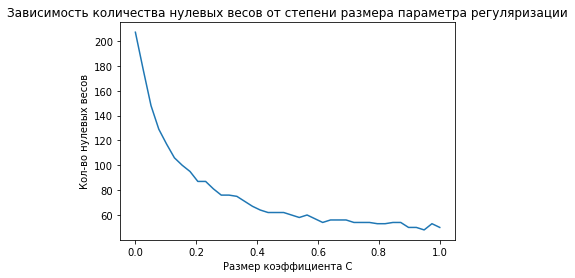

In [13]:
l1_zero_stat = (df_l1 == 0).sum()
plt.plot(c_values, l1_zero_stat)
plt.title('Зависимость количества нулевых весов от степени размера параметра регуляризации')
plt.xlabel('Размер коэффициента С')
plt.ylabel('Кол-во нулевых весов')
plt.show()

Как видно из полученного графика чем меньше значение С, тем больше сила регуляризации и большее количество признаков обнуляются через нулевые веса.

Теперь посмотрим как изменяются размеры весов в зависимости от размера коэфициента регуляризации.

In [14]:
print('Таблица статистических показателей для признаков с L1-регуляризацией')
df_l1.T.describe()

Таблица статистических показателей для признаков с L1-регуляризацией


,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Other,action_type_Pullup Jump shot,action_type_Putback Layup Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_1,period_2,period_3,period_4,period_5,period_6,period_7,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3,shot_zone_range_16-24 ft.,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,game_year_1996,game_year_1997,game_year_1998,game_year_1999,game_year_2000,game_year_2001,game_year_2002,game_year_2003,game_year_2004,game_year_2005,game_year_2006,game_year_2007,game_year_2008,game_year_2009,game_year_2010,game_year_2011,game_year_2012,game_year_2013,game_year_2014,game_year_2015,game_year_2016,game_month_1,game_month_2,game_month_3,game_month_4,game_month_5,game_month_6,game_month_10,game_month_11,game_month_12,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,"loc_x_(-250.498, -230.08]","loc_x_(-230.08, -210.16]","loc_x_(-210.16, -190.24]","loc_x_(-190.24, -170.32]","loc_x_(-170.32, -150.4]","loc_x_(-150.4, -130.48]","loc_x_(-130.48, -110.56]","loc_x_(-110.56, -90.64]","loc_x_(-90.64, -70.72]","loc_x_(-70.72, -50.8]","loc_x_(-50.8, -30.88]","loc_x_(-30.88, -10.96]","loc_x_(-10.96, 8.96]","loc_x_(8.96, 28.88]","loc_x_(28.88, 48.8]","loc_x_(48.8, 68.72]","loc_x_(68.72, 88.64]","loc_x_(88.64, 108.56]","loc_x_(108.56, 128.48]","loc_x_(128.48, 148.4]","loc_x_(148.4, 168.32]","loc_x_(168.32, 188.24]","loc_x_(188.24, 208.16]","loc_x_(208.16, 228.08]","loc_x_(228.08, 248.0]","loc_y_(-44.835, -10.6]","loc_y_(-10.6, 22.8]","loc_y_(22.8, 56.2]","loc_y_(56.2, 89.6]","loc_y_(89.6, 123.0]","loc_y_(123.0, 156.4]","loc_y_(156.4, 189.8]","loc_y_(189.8, 223.2]","loc_y_(223.2

In [15]:
print('Таблица статистических показателей для признаков с L2-регуляризацией')
df_l2.T.describe()

Таблица статистических показателей для признаков с L2-регуляризацией


,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Other,action_type_Pullup Jump shot,action_type_Putback Layup Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_1,period_2,period_3,period_4,period_5,period_6,period_7,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3,shot_zone_range_16-24 ft.,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,game_year_1996,game_year_1997,game_year_1998,game_year_1999,game_year_2000,game_year_2001,game_year_2002,game_year_2003,game_year_2004,game_year_2005,game_year_2006,game_year_2007,game_year_2008,game_year_2009,game_year_2010,game_year_2011,game_year_2012,game_year_2013,game_year_2014,game_year_2015,game_year_2016,game_month_1,game_month_2,game_month_3,game_month_4,game_month_5,game_month_6,game_month_10,game_month_11,game_month_12,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,"loc_x_(-250.498, -230.08]","loc_x_(-230.08, -210.16]","loc_x_(-210.16, -190.24]","loc_x_(-190.24, -170.32]","loc_x_(-170.32, -150.4]","loc_x_(-150.4, -130.48]","loc_x_(-130.48, -110.56]","loc_x_(-110.56, -90.64]","loc_x_(-90.64, -70.72]","loc_x_(-70.72, -50.8]","loc_x_(-50.8, -30.88]","loc_x_(-30.88, -10.96]","loc_x_(-10.96, 8.96]","loc_x_(8.96, 28.88]","loc_x_(28.88, 48.8]","loc_x_(48.8, 68.72]","loc_x_(68.72, 88.64]","loc_x_(88.64, 108.56]","loc_x_(108.56, 128.48]","loc_x_(128.48, 148.4]","loc_x_(148.4, 168.32]","loc_x_(168.32, 188.24]","loc_x_(188.24, 208.16]","loc_x_(208.16, 228.08]","loc_x_(228.08, 248.0]","loc_y_(-44.835, -10.6]","loc_y_(-10.6, 22.8]","loc_y_(22.8, 56.2]","loc_y_(56.2, 89.6]","loc_y_(89.6, 123.0]","loc_y_(123.0, 156.4]","loc_y_(156.4, 189.8]","loc_y_(189.8, 223.2]","loc_y_(223.2

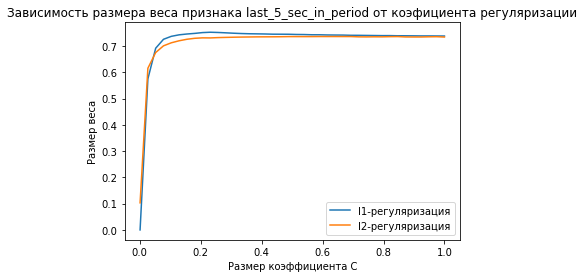

In [16]:
plt.plot(c_values, df_l1.T.last_5_sec_in_period.abs(), label='l1-регуляризация')
plt.plot(c_values, df_l2.T.last_5_sec_in_period.abs(), label='l2-регуляризация')
plt.title('Зависимость размера веса признака last_5_sec_in_period от коэфициента регуляризации')
plt.xlabel('Размер коэффициента С')
plt.ylabel('Размер веса')
plt.legend()
plt.show()

Из графика видно, что l2-регуляризация дает немного меньший размер весов.

Разделим выборку на обучающую и тестовую, обучим логистическую регрессию с L1- и L2- регуляризацией.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
                                                            
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [18]:
lr_l1 = LogisticRegression(penalty='l1', C=0.3, solver='liblinear')
lr_l1.fit(X_train_std, y_train)

lr_l2 = LogisticRegression(penalty='l2', C=0.3, solver='liblinear')
lr_l2.fit(X_train_std, y_train)

LogisticRegression(C=0.3, solver='liblinear')

Построим ROC-кривую для наших моделей.

In [19]:
fpr_l1, tpr_l1, thr_l1 = roc_curve(y_test, lr_l1.predict_proba(X_test)[:,1])
fpr_l2, tpr_l2, thr_l1 = roc_curve(y_test, lr_l2.predict_proba(X_test)[:,1])

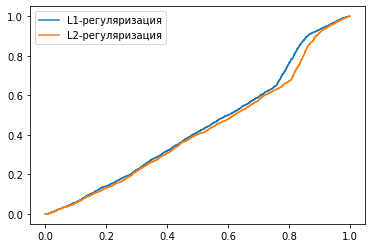

In [20]:
plt.plot(fpr_l1, tpr_l1, label='L1-регуляризация')
plt.plot(fpr_l2, tpr_l2, label='L2-регуляризация')
plt.legend()
plt.show()

Обе модели имеют низкое качество с текущими параметрами регулязирации.

Теперь попробуем сжать признаки с помощью PCA и посмотреть распределение дисперсии по главным компонентам.

Методом подбора кол-ва компонент определяем, что 160 главных компонент объясняют более 98% дисперсии данных.

In [21]:
pca = PCA(n_components=160)
pca.fit(X_train_std)

PCA(n_components=160)

In [22]:
sum(pca.explained_variance_ratio_)

0.9833479154946022

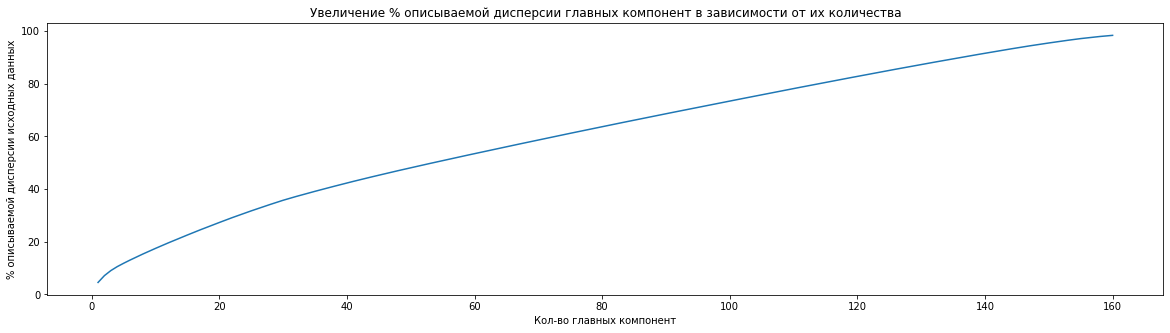

In [23]:
exp_ratio_cumm = np.cumsum(pca.explained_variance_ratio_ * 100)
plt.figure(figsize=(20,5))
plt.plot(range(1, 161), exp_ratio_cumm)
plt.title('Увеличение % описываемой дисперсии главных компонент в зависимости от их количества')
plt.xlabel('Кол-во главных компонент')
plt.ylabel('% описываемой дисперсии исходных данных')
plt.show()

Как видно из графика каждая главная компонента объясняет небольшую часть дисперсии исходных данных и нет сильного перевеса в сторону нескольких первых главных компонент. Чтобы объяснить 98% данных нам потребовалось 160 главных компонент. При этом исходное количество признаков - 208.